In [106]:
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


def gerar_caminhoes():
    caminhoes = []

    for i in range(10):
        caminhao = {
            "id": i + 1,
            "volume": 200,
            "peso": 2000,
            "volume_usado": 0,
            "peso_usado": 0,
            "valor_minimo": 4000
        }
        caminhoes.append(caminhao)
    return caminhoes

# Dados dos produtos (Fardo de Latas e Engradado de Garrafas)
produtos = [
    {"id": 1, "nome": "Fardo de Latas", "volume": 0.2, "peso": 30, "valor": 150, "fragil": False },
    {"id": 2, "nome": "Engradado de Garrafas", "volume": 0.5, "peso": 20, "valor": 100, "fragil": False },
    {"id": 3, "nome": "Caixa de amendoin", "volume": 0.3, "peso": 10, "valor": 50, "fragil": True },
    {"id": 4, "nome": "Caixa de vinho", "volume": 0.3, "peso": 20, "valor": 100, "fragil": True },
    {"id": 5, "nome": "Caixa de chá gelado", "volume": 0.4, "peso": 14, "valor": 20, "fragil": True },
    {"id": 6, "nome": "Pacote de farinha de trigo", "volume": 0.6, "peso": 25, "valor": 35, "fragil": False },
]

# Gerar uma lista de 1000 produtos aleatórios
def gerar_produtos_amostra():
    np.random.seed(42)
    produtos_amostra = [
        {**random.choice(produtos), "id": i + 1} for i in range(900)
    ]
    return produtos_amostra


class AlgoritmoGenetico:

    def __init__(self, population_size=300, generations=500, mutation_rate=0.05, initial_population_method: str = "", selection_method: str = "", muration_method: str = "", dinamic_mutation_rate: bool = False):
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.caminhoes = gerar_caminhoes()
        self.produtos_amostra = gerar_produtos_amostra()
        self.fitness_scores = {
            "generations": [],
            "best_fitness": [],
        }
        self.initial_population_method = initial_population_method
        self.selection_method = selection_method
        self.muration_method = muration_method
        self.dinamic_mutation_rate = dinamic_mutation_rate

    def fitness(self, solution):
        valor_total = 0
        penalidade = 0
        
        # Resetar volume e peso usados antes de calcular a fitness
        for caminhao in self.caminhoes:
            caminhao["volume_usado"] = 0
            caminhao["peso_usado"] = 0

        for caminhao in self.caminhoes:
            volume_usado = 0
            peso_usado = 0
            possui_fragil = False
            possui_nao_fragil = False

            for produto, alocacao in zip(self.produtos_amostra, solution):
                if alocacao == caminhao["id"]:
                    volume_usado += produto["volume"]
                    peso_usado += produto["peso"]
                    valor_total += produto["valor"]

                    # Marcar a presença de produtos frágeis ou não frágeis
                    if produto["fragil"]:
                        possui_fragil = True
                    else:
                        possui_nao_fragil = True

            # Atualizar volume e peso usados
            caminhao["volume_usado"] += volume_usado
            caminhao["peso_usado"] += peso_usado

            # Penalidades por exceder capacidade
            if volume_usado > caminhao["volume"]:
                penalidade += (volume_usado - caminhao["volume"]) * 10
            if peso_usado > caminhao["peso"]:
                penalidade += (peso_usado - caminhao["peso"]) * 10

            valor_total = sum(produto["valor"] for produto, alocacao in zip(self.produtos_amostra, solution) if alocacao == caminhao["id"])
            if valor_total < caminhao["valor_minimo"]:
                penalidade += (caminhao["valor_minimo"] - valor_total) * 10

            # Penalidade por misturar produtos frágeis e não frágeis
            if possui_fragil and possui_nao_fragil:
                penalidade += 30  # Penalidade alta para misturas

        return valor_total - penalidade

    def generate_heuristic_solution(self):
        solution = []
        for produto in self.produtos_amostra:
            allocated = False
            for caminhao in self.caminhoes:
                if caminhao["volume_usado"] + produto["volume"] <= caminhao["volume"] and caminhao["peso_usado"] + produto["peso"] <= caminhao["peso"]:
                    solution.append(caminhao["id"])
                    caminhao["volume_usado"] += produto["volume"]
                    caminhao["peso_usado"] += produto["peso"]
                    allocated = True
                    break
            if not allocated:
                # Fallback to allocate to a random truck if no suitable truck is found
                random_truck = random.choice(caminhoes)
                solution.append(random_truck["id"])
                random_truck["volume_usado"] += produto["volume"]
                random_truck["peso_usado"] += produto["peso"]
        return solution

    # Função para gerar uma solução inicial
    def generate_solution(self):
        return [random.choice([c["id"] for c in self.caminhoes]) for _ in self.produtos_amostra]

    # Função para criar a população inicial
    def initialize_population(self):
        if (self.aggregate_fitness_score == "heuristic"):
            return [self.generate_heuristic_solution() for _ in range(self.population_size)]
        else:
            return [self.generate_solution() for _ in range(self.population_size)]

    # Função de seleção por torneio
    def selection(self, population, fitness_scores):
        if (self.selection_method == "tournament"):
            total_fitness = sum(fitness_scores)
            selection_probs = [f / total_fitness for f in fitness_scores]
            return random.choices(population, weights=selection_probs, k=2)
        else:
            return random.choices(population, weights=fitness_scores, k=2)

    # Função de cruzamento (crossover)
    def crossover(self, parent1, parent2):
        point = random.randint(0, len(parent1) - 1)
        child = parent1[:point] + parent2[point:]
        return child

    # Função de mutação
    def mutate(self, solution, mutation_rate):
        if (self.muration_method == "swap"):
            #  Exemplo: Mutação de troca
            index1 = random.randint(0, len(solution) - 1)
            index2 = random.randint(0, len(solution) - 1)
            solution[index1], solution[index2] = solution[index2], solution[index1]
        elif (self.muration_method == "inversion"):
            #  Mutação de inversão
            index1 = random.randint(0, len(solution) - 1)
            index2 = random.randint(0, len(solution) - 1)
            if index1 > index2:
                index1, index2 = index2, index1
            solution[index1:index2] = reversed(solution[index1:index2])
        else:
            # Mutação de substituição
            if random.random() < mutation_rate:
                index = random.randint(0, len(solution) - 1)
                solution[index] = random.choice([c["id"] for c in self.caminhoes])

    def plot_fitness(self, fitness_history):
        plt.ion()
        fig, ax = plt.subplots()

        line, = ax.plot([], [], marker='o', markersize=4, markevery=10)
        ax.set_xlabel('Gerações')
        ax.set_ylabel('Melhor Fitness')
        ax.set_title('Evolução do Fitness ao Longo das Gerações')

        for i in range(len(fitness_history)):
            line.set_data(range(i + 1), fitness_history[:i + 1])
            ax.set_xlim(0, len(fitness_history))
            ax.set_ylim(min(fitness_history) - 10, max(fitness_history) + 10)

            clear_output(wait=True)
            display(fig)
            plt.pause(0.1)

        plt.ioff()
        plt.show()


    def aggregate_fitness_score(self, generation, best_fitness):
        self.fitness_scores['generations'].append(generation)
        self.fitness_scores['best_fitness'].append(best_fitness)

    # Algoritmo Genético (Treinamento)
    def genetic_algorithm(self):
        global fitness_history

        population = self.initialize_population()
        mutation_rate = self.mutation_rate
        previous_best_fitness = None

        for generation in range(self.generations):
            # Avaliar a população
            fitness_scores = [self.fitness(sol) for sol in population]

            # Nova geração
            new_population = []
            for _ in range(self.population_size // 2):
                parent1, parent2 = self.selection(population, fitness_scores)
                child1 = self.crossover(parent1, parent2)
                child2 = self.crossover(parent2, parent1)

                self.mutate(child1, mutation_rate)
                self.mutate(child2, mutation_rate)

                new_population.extend([child1, child2])

            population = new_population

            # Melhor solução da geração
            best_fitness = max(fitness_scores)
            fitness_history.append(best_fitness)
            self.plot_fitness(fitness_history)

            if (self.dinamic_mutation_rate == True):
                # Atualizar a taxa de mutação dinamicamente
                if previous_best_fitness is not None and best_fitness == previous_best_fitness:
                    mutation_rate = min(mutation_rate * 1.5, 0.5)  # Aumentar a taxa de mutação em até 50%, máximo de 50%
                else:
                    mutation_rate = self.mutation_rate  # Voltar ao valor original se a fitness melhorar

            previous_best_fitness = best_fitness

            self.aggregate_fitness_score(generation, best_fitness)

        # Melhor solução final
        final_fitness_scores = [self.fitness(sol) for sol in population]
        best_final_solution = population[np.argmax(final_fitness_scores)]

        # Imprimir volume e peso usados por caminhão
        print("\nVolume e Peso Usados por Caminhão:")
        for caminhao in self.caminhoes:
            if caminhao["volume_usado"] > 0 or caminhao["peso_usado"] > 0:
                print(f"Caminhão {caminhao['id']} - Volume Usado: {caminhao['volume_usado']}m³, Peso Usado: {caminhao['peso_usado']}kg")

        # Filtrar caminhões não utilizados
        caminhoes_utilizados = [caminhao for caminhao in self.caminhoes if caminhao["volume_usado"] > 0 or caminhao["peso_usado"] > 0]

        return best_final_solution, max(final_fitness_scores)

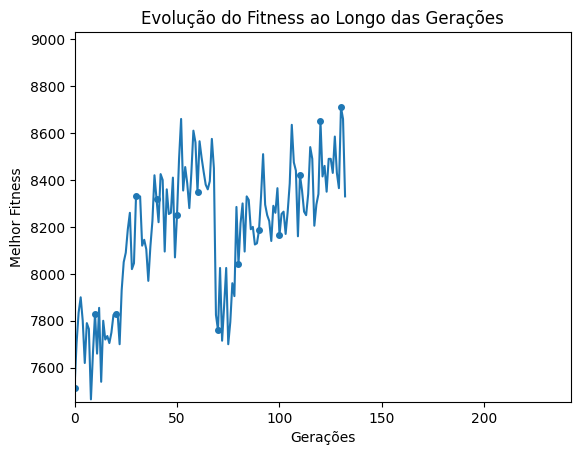

KeyboardInterrupt: 

In [ ]:
# Executar o AG e retornar a melhor solução
best_solution, best_fitness = AlgoritmoGenetico().genetic_algorithm()

# print("\nMelhor Solução Encontrada:", best_solution)
# print("\nMelhor fitness:", best_fitness) # 9630

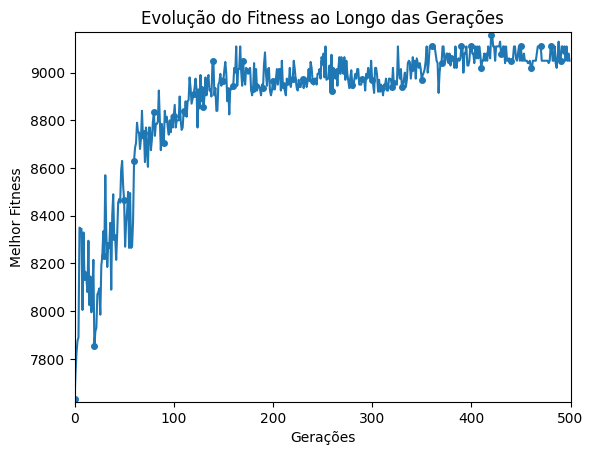

In [38]:
# Função para visualizar produtos
def visualizar_produtos():
    print("Produtos:")
    for produto in produtos_amostra:
        print(f"ID: {produto['id']}, Nome: {produto['nome']}, Volume: {produto['volume']}m³, Peso: {produto['peso']}kg, Valor: R${produto['valor']}")
    print("\n")

# Função para visualizar a alocação dos produtos
def visualizar_alocacao(solution):
    print("Alocação dos Produtos nos Caminhões:{solution}")
    for i, produto in enumerate(produtos_amostra):
        alocado_a_caminhao = solution[i]
        print(f"Produto {produto['nome']} (ID {produto['id']}) -> Caminhão {alocado_a_caminhao}")
    print("\n")

# Função para visualizar a carga total por caminhão (com gráfico)
def visualizar_carga_por_caminhao(solution):
    cargas_por_caminhao = {caminhao['id']: {'volume': 0, 'peso': 0, 'valor': 0} for caminhao in caminhoes}

    for i, produto in enumerate(produtos_amostra):
        alocado_a_caminhao = solution[i]
        for caminhao in caminhoes:
            if caminhao['id'] == alocado_a_caminhao:
                cargas_por_caminhao[caminhao['id']]['volume'] += produto['volume']
                cargas_por_caminhao[caminhao['id']]['peso'] += produto['peso']
                cargas_por_caminhao[caminhao['id']]['valor'] += produto['valor']

    # Remover caminhões sem carga
    cargas_por_caminhao = {k: v for k, v in cargas_por_caminhao.items() if v['volume'] > 0 or v['peso'] > 0}
    print(f"Carga Total por Caminhão: {cargas_por_caminhao}")

    # carga por caminhão
    volumes = [cargas_por_caminhao[caminhao]['volume'] for caminhao in cargas_por_caminhao]
    pesos = [cargas_por_caminhao[caminhao]['peso'] for caminhao in cargas_por_caminhao]
    valores = [cargas_por_caminhao[caminhao]['valor'] for caminhao in cargas_por_caminhao]
    
    # % carga ocupada
    eficiencia_volume = [vol / next(c['volume'] for c in caminhoes if c['id'] == caminhao) * 100 for vol, caminhao in zip(volumes, cargas_por_caminhao)]
    eficiencia_peso = [peso / next(c['peso'] for c in caminhoes if c['id'] == caminhao) * 100 for peso, caminhao in zip(pesos, cargas_por_caminhao)]

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))

    # Gráfico de volume por caminhão
    axs[0, 0].bar(cargas_por_caminhao.keys(), volumes, color='blue', alpha=0.7)
    axs[0, 0].set_title('Volume Total por Caminhão')
    axs[0, 0].set_xlabel('ID do Caminhão')
    axs[0, 0].set_ylabel('Volume (m³)')
    
    # Gráfico de peso por caminhão
    axs[0, 1].bar(cargas_por_caminhao.keys(), pesos, color='green', alpha=0.7)
    axs[0, 1].set_title('Peso Total por Caminhão')
    axs[0, 1].set_xlabel('ID do Caminhão')
    axs[0, 1].set_ylabel('Peso (kg)')

    # Gráfico de valor por caminhão
    axs[1, 0].bar(cargas_por_caminhao.keys(), valores, color='orange', alpha=0.7)
    axs[1, 0].set_title('Valor Total por Caminhão')
    axs[1, 0].set_xlabel('ID do Caminhão')
    axs[1, 0].set_ylabel('Valor (R$)')

    # Eficiência de carga (percentual de volume ocupado)
    axs[1, 1].bar(cargas_por_caminhao.keys(), eficiencia_volume, color='purple', alpha=0.7, label="Volume")
    axs[1, 1].bar(cargas_por_caminhao.keys(), eficiencia_peso, color='red', alpha=0.7, label="Peso")
    axs[1, 1].set_title('Eficiência de Carga (Volume e Peso Ocupados)')
    axs[1, 1].set_xlabel('ID do Caminhão')
    axs[1, 1].set_ylabel('Eficiência (%)')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

# Função para calcular o valor total das cargas alocadas
def calcular_valor_total(solution):
    valor_total = 0
    for i, produto in enumerate(produtos_amostra):
        alocado_a_caminhao = solution[i]
        for caminhao in caminhoes:
            if caminhao['id'] == alocado_a_caminhao:
                valor_total += produto['valor']
    return valor_total

Carga Total por Caminhão: {1: {'volume': 35.10000000000002, 'peso': 1900, 'valor': 7310}, 2: {'volume': 37.00000000000001, 'peso': 1795, 'valor': 6945}, 3: {'volume': 37.099999999999994, 'peso': 1884, 'valor': 6820}, 4: {'volume': 38.1, 'peso': 1882, 'valor': 7430}, 5: {'volume': 33.6, 'peso': 1793, 'valor': 6945}, 6: {'volume': 32.800000000000004, 'peso': 1511, 'valor': 5075}, 7: {'volume': 34.20000000000001, 'peso': 1784, 'valor': 6930}, 8: {'volume': 38.09999999999999, 'peso': 1874, 'valor': 6770}, 9: {'volume': 28.00000000000001, 'peso': 1443, 'valor': 5265}, 10: {'volume': 33.8, 'peso': 2007, 'valor': 8645}}


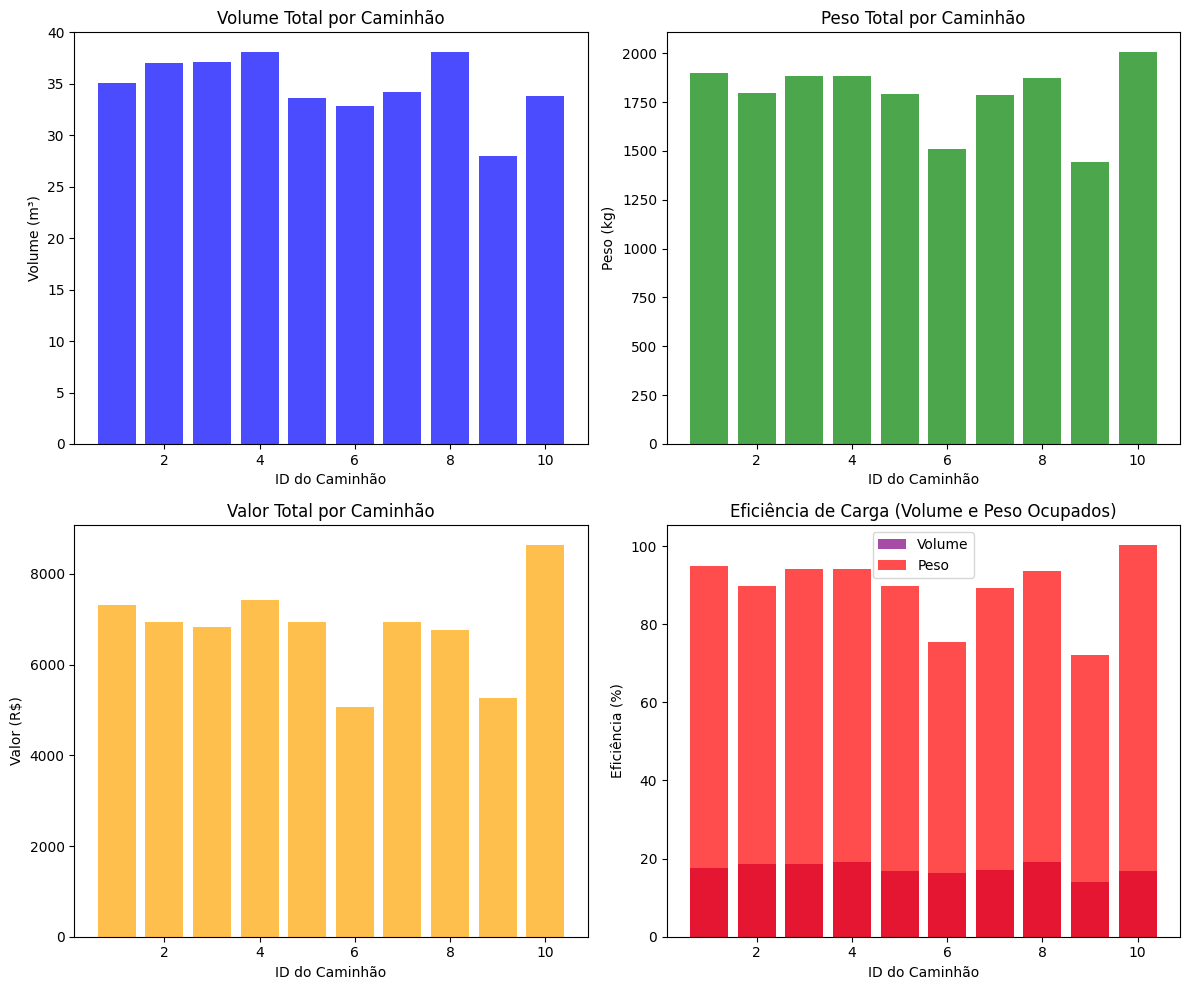

Valor Total das Cargas Alocadas: R$68135


In [39]:
# visualizar_produtos()
# visualizar_alocacao(best_solution)
visualizar_carga_por_caminhao(best_solution)
valor_total = calcular_valor_total(best_solution)

print(f"Valor Total das Cargas Alocadas: R${valor_total}")

In [40]:

def visualizar_carga_por_caminhao(solution):
    cargas_por_caminhao = {caminhao['id']: {'volume': 0, 'peso': 0, 'valor': 0} for caminhao in caminhoes}

    for i, produto in enumerate(produtos_amostra):
        alocado_a_caminhao = solution[i]
        for caminhao in caminhoes:
            if caminhao['id'] == alocado_a_caminhao:
                cargas_por_caminhao[caminhao['id']]['volume'] += produto['volume']
                cargas_por_caminhao[caminhao['id']]['peso'] += produto['peso']
                cargas_por_caminhao[caminhao['id']]['valor'] += produto['valor']

    print("Cargas por Caminhão:")
    for caminhao in caminhoes:
        carga = cargas_por_caminhao[caminhao['id']]
        print(f"Caminhão {caminhao['id']} - Volume Total: {round(carga['volume'], 3)}m³, Peso Total: {carga['peso']}kg, Valor Total: R${carga['valor']}")
    print("\n")

visualizar_carga_por_caminhao(best_solution)

Cargas por Caminhão:
Caminhão 1 - Volume Total: 35.1m³, Peso Total: 1900kg, Valor Total: R$7310
Caminhão 2 - Volume Total: 37.0m³, Peso Total: 1795kg, Valor Total: R$6945
Caminhão 3 - Volume Total: 37.1m³, Peso Total: 1884kg, Valor Total: R$6820
Caminhão 4 - Volume Total: 38.1m³, Peso Total: 1882kg, Valor Total: R$7430
Caminhão 5 - Volume Total: 33.6m³, Peso Total: 1793kg, Valor Total: R$6945
Caminhão 6 - Volume Total: 32.8m³, Peso Total: 1511kg, Valor Total: R$5075
Caminhão 7 - Volume Total: 34.2m³, Peso Total: 1784kg, Valor Total: R$6930
Caminhão 8 - Volume Total: 38.1m³, Peso Total: 1874kg, Valor Total: R$6770
Caminhão 9 - Volume Total: 28.0m³, Peso Total: 1443kg, Valor Total: R$5265
Caminhão 10 - Volume Total: 33.8m³, Peso Total: 2007kg, Valor Total: R$8645




In [ ]:
# 1. Pedro - Cacular fator de penalidade - funcão 
# 2. Junior - Desenhar a curva do fitness - se der gerar frame a frame
    # Plotar um grafico com o 500 resultados gerados e (best_solution)
    # Testar com mais gerações 5 mil exemplo
# 3. Matheus - Melhor visão dos produtos alocados nos caminhões
    # Mostrar a alocação grafico em como ficou em cada caminhão.
# 4. Pedro - Criar um streamlit para poder mudar os hiper parametros(mudar as funcões)
# ultima coisa - documentar o código